In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import brian2tools as b2t
import brian2 as b2
from scipy.integrate import solve_ivp

from lib.functions import VoltageMap, get_global_spikes

In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

# Brian Simulation

In [2]:
b2.start_scope()

N = 400
v_L = -67
v_I = -80
v_thr = -40
v_res = -70
duration = 1000*b2.ms
sigma = 0.1
I_dc = 3400/b2.second
g_L = 100/b2.second
tau = 0.1*b2.ms
tau_D = 20*b2.ms
tau_R = 20*b2.ms

initial_g = 100/b2.second
initial_v = np.random.uniform(low=v_res, high=v_thr, size=N)
w = 4


In [3]:
eqs = '''
    dv/dt = g_L*(v_L-v) + I_dc + w*g*(v_I - v) + sigma*xi*tau**-0.5 : 1
    dg/dt = (R-g)/tau_D : hertz
    dR/dt = -R/tau_R : hertz
'''

G = b2.NeuronGroup(
        N,
        eqs, 
        threshold='v>v_thr',
        reset='v=v_res'
    )

G.v = initial_v
G.g = initial_g


In [4]:
S2 = b2.Synapses(G, G, model='''w : hertz # synaptic weight''', on_pre='R+=w')

S2.connect(condition='True')
S2.w = 1*b2.hertz

spike_mon = b2.SpikeMonitor(G)
monitor = b2.StateMonitor(G, variables=['v', 'g'], record=True)
mon_syn = b2.StateMonitor(S2, variables=True, record=False)
rate_mon = b2.PopulationRateMonitor(G)

# a simple run would not include the monitors
net = b2.Network(b2.collect())  # automatically include G and S
net.add(monitor)  # manually add the monitors


net.run(duration)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.09s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    "w" is an internal variable of group "synapses", but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [5]:
volts = np.array(monitor.v)
time = np.array(monitor.t)
v_map = VoltageMap(volts, time, duration=duration, spikes=spike_mon.values('t'), v_res=v_res, v_thr=v_thr, v_resolution=200)


In [12]:
global_spikes, global_rate = get_global_spikes(rate_mon, duration, v_map)

In [14]:
global_spikes

,peak_time,next_cycle,%_spiking_neurons,start_spikes,mu,var,end_spikes
0,0.0000,0.03430,NaN,NaN,NaN,NaN,NaN
1,0.0686,0.10995,14.00,0.0672,-41.477280,0.438168,0.0703
2,0.1513,0.18410,7.25,0.1468,-42.186676,0.409973,0.1547
3,0.2169,0.25105,8.00,0.2119,-42.110029,0.478591,0.2217
4,0.2852,0.31965,8.50,0.2815,-41.839557,0.377493,0.2877
5,0.3541,0.38830,8.25,0.3506,-42.053346,0.385977,0.3556
6,0.4225,0.45315,6.50,0.4193,-41.966378,0.461733,0.4255
7,0.4838,0.51290,5.75,0.4804,-42.014312,0.388837,0.4885
8,0.5420,0.57315,6.75,0.5390,-41.849983,0.420375,0.5446
9,0.6043,0.63155,5.25,0.6001,-42.219909,0.392757,0.6064


In [7]:
v_map.mean[v_map.time_id(start_time.min())-1] 

-41.87820338003686

In [46]:
p_vth = lambda row: N*(1+sp.special.erf((row.mu-v_thr)/(np.sqrt(2)*np.sqrt(row['var']))))
prob_spiking = global_spikes.apply(p_vth, axis=1).iloc[2:-1]

In [47]:
v_map.spikes

0    0    222.4 ms
1    0    0.6059 s
     1    0.8065 s
2    0     69.1 ms
5    0    223.3 ms
            ...   
395  0    0.3464 s
396  0    0.5364 s
398  0    0.8065 s
399  0     68.6 ms
     1    221.7 ms
Length: 448, dtype: object

# Reduced model Simulation

In [48]:
cycle = 4
t0 = global_spikes.loc[cycle, 'peak_time']
t_end = global_spikes.loc[cycle+1, 'peak_time']
id_t0 = int(t0*10000 + 0.5)	
id_t_end = int(t_end*10000 + 0.5)


S_t = np.mean(np.array(monitor.g), axis=0)
G_t = S_t*b2.hertz
G_t0 = G_t[id_t0]
t = monitor.t[id_t0: id_t_end]


In [49]:
def d_mu_dt_generator(g_L, v_L, I_dc, G_t, v_I, w):
# Generates d(mu)/dt
    def d_mu_dt(t, mu):
        g_syn = w*G_t[int(t*10000 + 0.5)]
        a = g_L + g_syn
        b = g_L*v_L + I_dc + g_syn*v_I
        return float(-a*mu + b)
    return d_mu_dt

def d_var_dt_generator(G_t, g_L, sigma, tau, w):
    def d_var_dt(t, var):
        g_syn = w*G_t[int(t*10000 + 0.5)]
        a = g_L + g_syn
        return float(-2*a*var**2 + sigma**2/(tau))
    return d_var_dt

d_mu_dt = d_mu_dt_generator(g_L, v_L, I_dc, G_t, v_I, w)
d_var_dt = d_var_dt_generator(G_t, g_L, sigma, tau, w)

In [52]:
mu_0 = v_map.mean[id_t0]
mu = solve_ivp(
    fun=d_mu_dt, 
    t_span=(t0, t_end),
    y0=[mu_0],
    method='DOP853',
    t_eval=np.linspace(t0, t_end, 1000)
)

var_0 = v_map.std[id_t0]
var = solve_ivp(
    fun=d_var_dt, 
    t_span=(t0, t_end),
    y0=[var_0],
    method='DOP853',
    t_eval=np.linspace(t0, t_end, 1000)
)

# Results

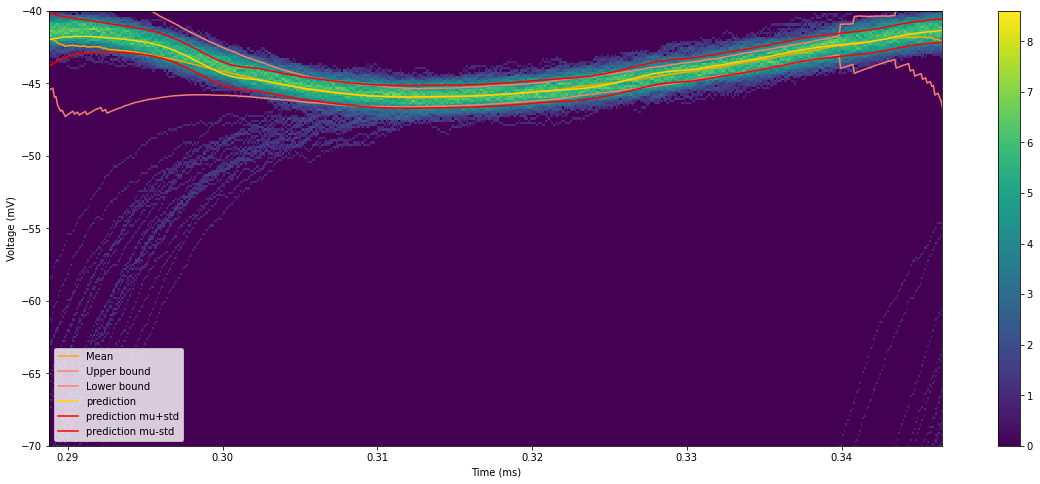

In [54]:
v_map.plot_density(t0, t_end)
plt.plot(mu.t, mu.y[0], label='prediction', color='gold')
plt.plot(var.t, mu.y[0]+np.sqrt(var.y[0]), color='red', label='prediction mu+std')
plt.plot(var.t, mu.y[0]-np.sqrt(var.y[0]), color='red', label='prediction mu-std')
plt.legend()
#plt.savefig('../figures/voltage_distribution2.png')

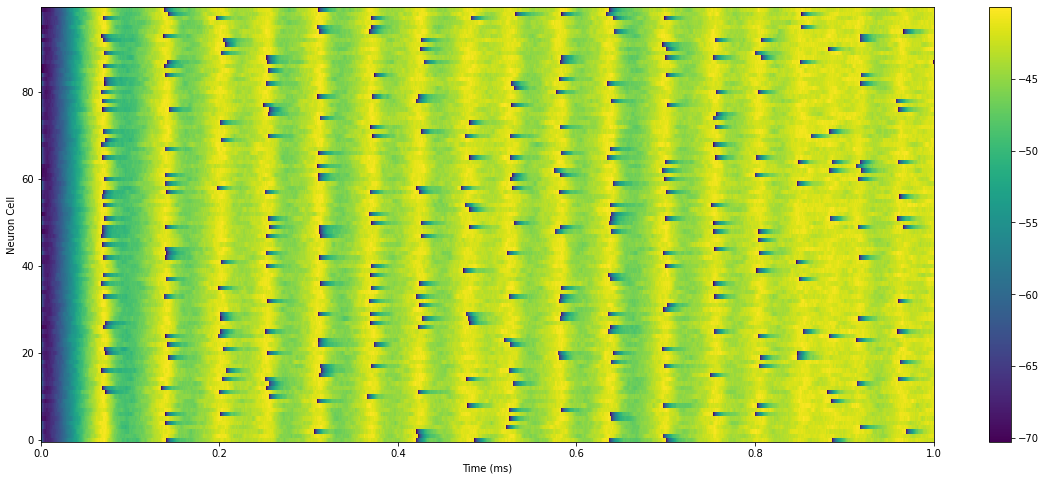

In [11]:
v_map.plot_rasterplot()
#plt.savefig('../figures/rasterplot2.png')

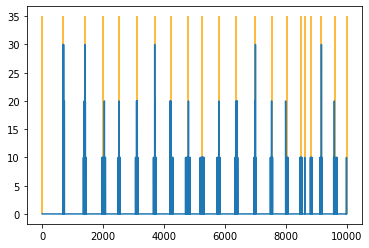

In [14]:
plt.plot(global_rate.index, global_rate['rate']/10)
#plt.plot(global_rate.index, global_rate['rate_smooth'])
plt.vlines(global_spikes['peak_time']*10000, 0, 35, color="orange")

# Firing period

In [4]:
# medir S_b
# Mostrar dos medias diferentes, una para los que siguen y otra para todos

In [5]:
global_spikes

NameError: name 'global_spikes' is not defined